### Задачи

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

### Необходимые библиотеки

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from dateutil import parser
from datetime import timedelta
from matplotlib import pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

plt.style.use('Solarize_Light2')

%matplotlib inline

### Данные

In [3]:
# таблица с уникальными идентификаторами пользователей
customers = pd.read_csv('olist_customers_dataset.csv')

# таблица заказов
orders = pd.read_csv('olist_orders_dataset.csv')

# товарные позиции, входящие в заказы
items = pd.read_csv('olist_order_items_dataset.csv')

In [18]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

In [27]:
customers.shape

(99441, 5)

In [19]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [20]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [4]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

In [25]:
orders.shape

(99441, 8)

In [10]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [14]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

В дальнейшем, при работе с датасетами, надо будет преобразовывать order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date во временной формат, т.к. в данном датасете они представлены в виде object.

In [5]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [26]:
items.shape

(112650, 7)

In [11]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [15]:
items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

 ## Решение

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Посмотрим, какие статусы у нас есть вообще

In [7]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

##### Уникальные статусы заказов
- created —  создан
- approved —  подтверждён
- invoiced —  выставлен счёт
- processing —  в процессе сборки заказа
- shipped —  отгружен со склада
- delivered —  доставлен пользователю
- unavailable —  недоступен
- canceled —  отменён

Считаю, что нужно оставить статус только 'delivered', так как товар уже доставлен и принят клиентом. Статусы 'approved', 'created', 'processing', invoiced' вряд ли подойдут, ибо это начальная стадия заказа и она не даёт гарантии того, что клиент получит товар или не оформит возврат. Статусы 'unavailable', 'canceled' тоже не подходят, так как клиент точно не получил заказ, 'shipped' близок к правде, но клиент может не прийти за товаром/не открыть дверь/вернуть если что-то не понравится. А вот статус 'delivered' как раз подходит. Есть, конечно, вероятность, что клиент может вернуть товар, но это неизбежно, так как есть вероятность брака и т.д.

In [34]:
"""
1. Отфильтровать те заказы, статус которых соответствует покупке (на выбор)
2. Для каждого пользователя рассчитать количество покупок
3. Отфильтровать пользователей с 1 покупкой
4. Посчитать количество уникальных customer_id
"""

customers_with_one_purchase = (
    orders
    .query('order_status == "delivered"')
    .merge(customers, on='customer_id')
    .groupby('customer_unique_id', as_index=False)
    .order_id
    .nunique()
    .query('order_id == 1')
    .customer_unique_id
    .nunique()
)

In [35]:
customers_with_one_purchase

90557

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

В данном случае статус 'delivered' не подходит по причине того, что нужно найти заказы, которые не доставили.

In [50]:
monthly = orders[orders.order_status != 'delivered']
monthly.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


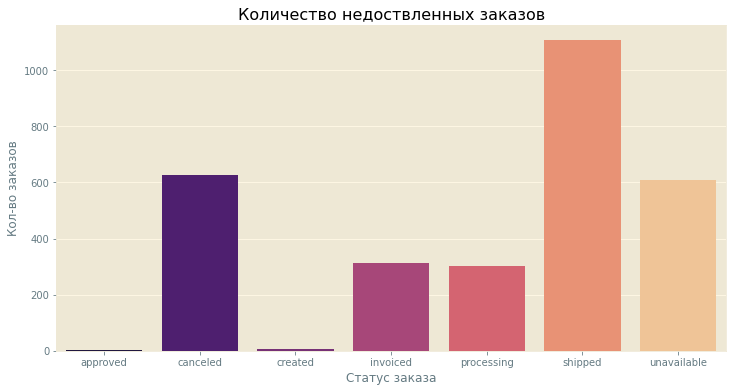

In [87]:
status = monthly.groupby('order_status') \
                .agg({'order_id': 'count'}) \
                .rename(columns={'order_id': 'orders_count'}) \
                .reset_index()

fig = plt.figure(figsize=(12,6))

z = sns.barplot(x=status['order_status'], y=status['orders_count'], data=status, palette='magma')
z.set_xlabel("Статус заказа")
z.set_ylabel("Кол-во заказов")
z.set(title="Количество недоствленных заказов")
plt.show()

In [88]:
status

,order_status,orders_count
0,approved,2
1,canceled,625
2,created,5
3,invoiced,314
4,processing,301
5,shipped,1107
6,unavailable,609


Считаю, что корректно будет выделить заказы со статусами 'canceled' и 'unavailable', так как в других статусах нет основания полагать, что они не доставлены или не доставятся.

In [60]:
"""
1. Отфильтровать те заказы, статус которых соответствует негативному событию ('unavailable', 'canceled')
2. Рассчитать месяц на основе дат (самый простойвраиант - отрезать год и месяц)
3. Для каждого месяца и каждого негативного статуса рассчитать уникальное количество заказов
4. Для каждого статуса рассчитать среднее количество заказов по месяцам
"""

mean_undelivered_orders = (
    orders[orders.order_status.isin(['unavailable', 'canceled'])]
    .assign(month = lambda row: row.order_purchase_timestamp.str[:7])
    .groupby(['month', 'order_status'], as_index=False)
    .order_id.nunique()
    .groupby('order_status', as_index=False)
    .order_id.mean()
    .round()
)

In [59]:
mean_undelivered_orders

,order_status,order_id
0,canceled,26.0
1,unavailable,29.0


## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Здесь нужны два датафрейма: orders и items.

In [67]:
"""
1. Ктаблице items приджойнить поле order_purchase_timestamp из orders
2. Из поля order_purchase_timestamp получить номер дня внутри недели (можно с помощью isocalendar)
3. Для каждого товара выделить день, которому соответствует наибольшее количество продаж (можно
с помощью value_counts())
"""

orders_items = (
    items
        .merge(
            orders[['order_id', 'order_purchase_timestamp']],
            on='order_id',
            how='left'
        )
)

In [68]:
orders_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51


In [81]:
orders_items['day_of_week'] = (
    orders_items
        .order_purchase_timestamp
        .apply(lambda x: parser.parse(x).isocalendar()[2])
)

In [82]:
orders_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,dayofweek,day_of_week
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,3,3
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,3,3
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,7,7
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,3,3
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,6,6


In [84]:
day_of_week = (
    orders_items
        .groupby('product_id', as_index=False)
        .day_of_week.apply(lambda x: x.value_counts().index[0])
)

In [95]:
day_of_week

,product_id,day_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,7
1,00088930e925c41fd95ebfe695fd2655,2
2,0009406fd7479715e4bef61dd91f2462,4
3,000b8f95fcb9e0096488278317764d19,3
4,000d9be29b5207b54e86aa1b1ac54872,2
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,7
32947,fff81cc3158d2725c0655ab9ba0f712c,1
32948,fff9553ac224cec9d15d49f5a263411f,5
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,2



## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
 Не стоит забывать, что внутри месяца может быть не целое количество недель.
 Например в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть

In [93]:
'''
1. Для каждого месяца в датасете рассчитать количеств дней
2. Выделить количество недель внутри месяца, поделив количество дней на 7
3. Отфильтровать заказы в статусах, несоответствующих покупке
4. Приждойник к orders уникакльные идентификаторы пользователей
5. Добавить к orders колонку с месяцем покупки
6. Для каждого пользователя внутри месяца рассчитать общее количество заказов
7. К orders приджойнить количество недель по месяцам
8. Поделить кол-во заказов по пользователям/месяцам на кол-во недель в месяце'''

calendar = pd.DataFrame(
    pd.date_range(
        orders.order_purchase_timestamp.min()[:10],
        orders.order_purchase_timestamp.max()[:10]
    ),
    columns=['dates']
)
calendar['month'] = calendar.dates.apply(lambda x: x.isoformat()[:7])
calendar = (
    calendar
        .groupby('month', as_index=False)
        .dates.nunique()
        .assign(weeks_count = lambda x: x.dates / 7)
        [['month', 'weeks_count']]
        .round(2)
)

In [103]:
calendar.head()

,month,weeks_count
0,2016-09,3.86
1,2016-10,4.43
2,2016-11,4.29
3,2016-12,4.43
4,2017-01,4.43


In [101]:
mean_purches_by_month = (
    orders[~orders.order_status.isin(['created'])]
        .merge(
            user[['customer_id', 'customer_unique_id']],
            on='customer_id',
            how='left'
        )
        .assign(month = lambda row: row.order_purchase_timestamp.str[:7])
        .groupby(['customer_unique_id', 'month'], as_index=False)
        .order_id.nunique()
        .merge(calendar, on='month', how='left')
        .assign(orders_weekly_frequency = lambda x: x.order_id / x.weeks_count)
        [['customer_unique_id', 'month', 'orders_weekly_frequency']]
        .round(2)
)

In [102]:
mean_purches_by_month

,customer_unique_id,month,orders_weekly_frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.23
2,0000f46a3911fa3c0805444483337064,2017-03,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.23
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.23
...,...,...,...
98036,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.23
98037,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.23
98038,ffff371b4d645b6ecea244b27531430a,2017-02,0.25
98039,ffff5962728ec6157033ef9805bacc48,2018-05,0.23


## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

1. Отфильтровать только те заказы, которые считаются "успешными"
2. Обогатить информацией об уникальном идентификаторе пользователя
3. Добавить для каждого пользователя его когорту, расчитаную по месяцу первого заказа
4. С помощью cumcount для каждого заказа внутри кагорты рассчитать его порядковый номер месяца
5. Построить сводную таблицу с кол-вом вернувшихся пользователей внутри кагорты на N-ый месяц жизни каготры
6. С помощью div перевести кол-во пользователей в доли

In [126]:
# 1. Фильтрую только те заказы, которые считаются "успешными"
# 2. Обогатил информацией об уникальном идентификаторе пользователя
order_status_created = (
    orders[~orders.order_status.isin(['created'])]
    .merge(
        customers[['customer_id', 'customer_unique_id']],
        on='customer_id',
        how='left'
    )
)

In [127]:
# 3. Добавил для каждого пользователя его когорту, расчитаную по месяцу первого заказа
order_status_created['month'] = order_status_created['order_purchase_timestamp'].apply(lambda x: x[:7])

order_status_created = order_status_created.merge(
    order_status_created
        .groupby('customer_unique_id', as_index=False)
        .month.min()
        .rename({'month': 'cohort'}, axis=1),
    on='customer_unique_id',
    how='left'
)

In [128]:
# 4. С помощью cumcount для каждого заказа внутри кагорты рассчитал его порядковый номер месяца
order_status_created['ret_month'] = (
    order_status_created
        .groupby('customer_unique_id', as_index=False)
        .month
        .cumcount()
)
order_status_created['retention'] = 1

In [129]:
# 5. Построил сводную таблицу с кол-вом вернувшихся пользователей внутри кагорты на N-ый месяц жизни каготры
order_status_created = pd.pivot_table(
    order_status_created,
    values='retention',
    index='cohort',
    columns='ret_month',
    aggfunc=np.sum
)

In [131]:
# 6. С помощью div перевёл кол-во пользователей в доли
order_status_created = order_status_created.div(order_status_created[0], axis=0).fillna(0).drop(0, axis=1)

In [122]:
order_status_created

ret_month,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
cohort,,,,,,,,,,,,,,,,
2016-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10,0.037383,0.003115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-12,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01,0.075916,0.013089,0.002618,0.001309,0.001309,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-02,0.041667,0.003995,0.000571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-03,0.049317,0.006449,0.001138,0.000379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-04,0.045918,0.004252,0.000425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-05,0.055061,0.007786,0.001669,0.000834,0.000834,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278
2017-06,0.055113,0.004141,0.000637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


##### Для удобства анализа полученной таблицы воспользовался методом "heatmap" из библиотеки seaborn

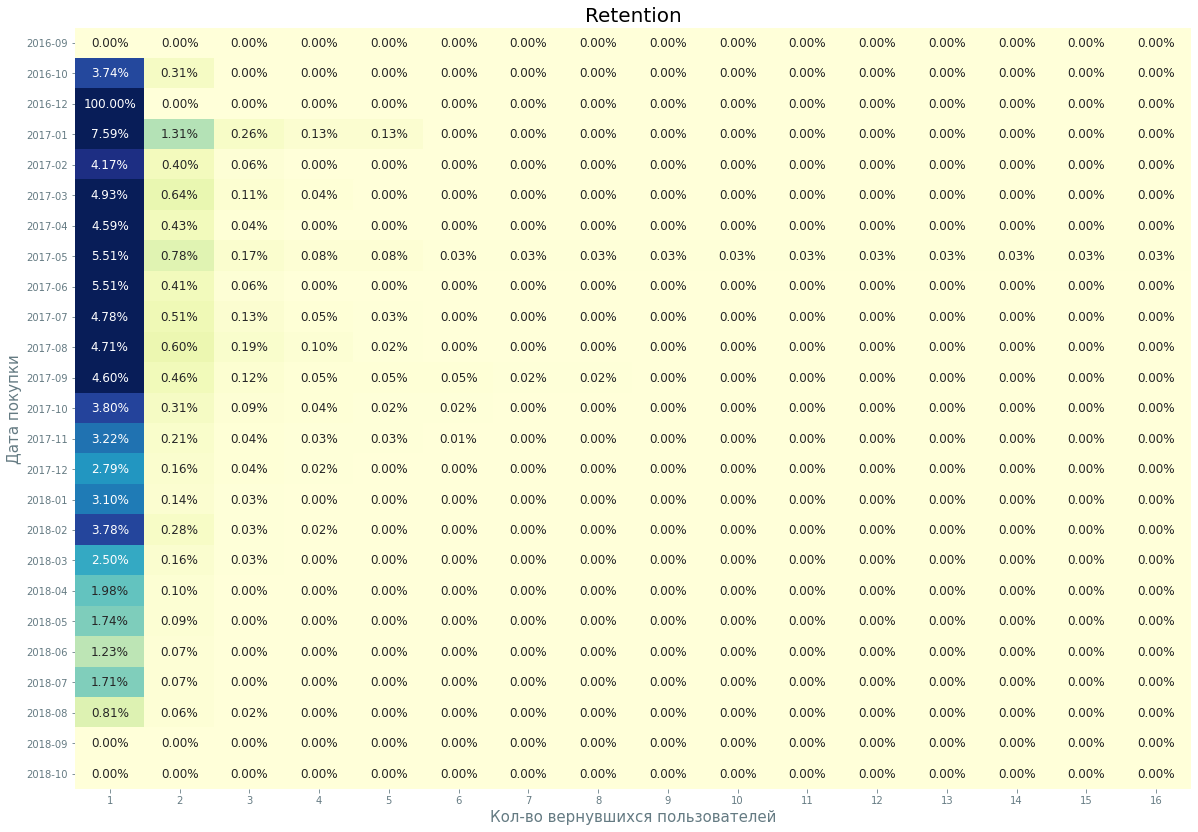

In [140]:
plt.figure(figsize=(20, 14))
sns.heatmap(order_status_created, robust=True, annot=True, cbar=False, cmap="YlGnBu", fmt='.2%', annot_kws={"fontsize":12})
plt.title('Retention', fontsize=20)
plt.xlabel('Кол-во вернувшихся пользователей', fontsize=15)
plt.ylabel('Дата покупки', fontsize=15)
plt.show()

## 6. Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary

Рассчёт от каждого заказа до максимально возможного времени внутри датасета

In [4]:
max_date = parser.parse(orders.order_purchase_timestamp.max())

max_date

datetime.datetime(2018, 10, 17, 17, 30, 18)

In [5]:
orders['days_to_max'] = list(map(lambda x: x.days, (max_date - orders.order_purchase_timestamp.apply(parser.parse))))

In [12]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,days_to_max
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,380
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,84
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,70
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,332
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,245


1. Рассчёт стоимости заказа для каждого заказа в данных
2. Приджойнить стоимость и уникальные id пользователей к данным
3. Для каждого пользователя вычислить:
    * срок в днях от его последнего заказа
    * суммарное кол-во заказов
    * общую сумму заказов

In [6]:
order_price = (
    orders[~orders.order_status.isin(['created'])]
    .merge(
        customers[['customer_id', 'customer_unique_id']],
        on='customer_id',
        how='left'
    )
    .merge(
        items
            .groupby('order_id', as_index=False)
            .price.sum()
    )
    .groupby('customer_unique_id', as_index=False)
    .agg({'order_id': 'size', 'days_to_max': 'min', 'price': 'sum'}))



In [7]:
order_price.head()

,customer_unique_id,order_id,days_to_max,price
0,0000366f3b9a7992bf8c76cfdf3221e2,1,160,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,163,18.90
2,0000f46a3911fa3c0805444483337064,1,585,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,369,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,336,180.00


Кластеризация: разбиение по квартилям этих метрик

In [8]:
intervals_r = list(order_price.days_to_max.describe())[3:]
intervals_f = [1, 2, 3, 16]
intervals_m = list(order_price.price.describe())[3:]

Для расчёта RFM-кластеров выбираю методику e-comn:
* R - время в днях с последнего заказа
* F - кол-во заказов за всё время
* M - общая сумма покупок за всё время

С помощью np.digitize присвоить каждому пользователю квартиль внутри метрики

In [9]:
order_price['recency'] = order_price.days_to_max.apply(lambda x: np.digitize(x, intervals_r))

In [10]:
order_price['frequency'] = order_price.order_id.apply(lambda x: np.digitize(x, intervals_f))

In [11]:
order_price['monetary'] = order_price.price.apply(lambda x: np.digitize(x, intervals_m))

In [12]:
order_price['RFM'] = order_price.recency.astype('str') + order_price.frequency.astype('str') + order_price.monetary.astype('str')

In [13]:
order_price

,customer_unique_id,order_id,days_to_max,price,recency,frequency,monetary,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,1,160,129.90,1,1,3,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,163,18.90,2,1,1,211
2,0000f46a3911fa3c0805444483337064,1,585,69.00,4,1,2,412
3,0000f6ccb0745a6a4b88665a16c9f078,1,369,25.99,3,1,1,311
4,0004aac84e0df4da2b147fca70cf8255,1,336,180.00,3,1,4,314
...,...,...,...,...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,1,495,1570.00,4,1,4,414
95416,fffea47cd6d3cc0a88bd621562a9d061,1,310,64.89,3,1,2,312
95417,ffff371b4d645b6ecea244b27531430a,1,617,89.90,4,1,3,413
95418,ffff5962728ec6157033ef9805bacc48,1,168,115.00,2,1,3,213


Рассчёт стоимость заказа для каждого заказа в данных

In [14]:
order_price.groupby('RFM', as_index=False)['order_id', 'days_to_max', 'price'].mean().round().head()

,RFM,order_id,days_to_max,price
0,111,1.0,105.0,29.0
1,112,1.0,104.0,66.0
2,113,1.0,107.0,118.0
3,114,1.0,107.0,366.0
4,121,2.0,102.0,36.0


Результирующая таблица по каждому покупателю, с отношением его к определенному RFM-кластеру готова.

Далее, разобъем на группы со средними значениями по каждой метрике:

In [15]:
rfm_grouped = order_price.groupby('RFM').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'})
rfm_grouped.value_counts().count() # 48 кластеров

48

In [16]:
rfm_graph = order_price.groupby('RFM', as_index=False) \
               .agg({'customer_unique_id': 'count'}) \
               .rename(columns={'customer_unique_id': 'num_of_customers'})
rfm_graph.head()

,RFM,num_of_customers
0,111,5892
1,112,5711
2,113,5830
3,114,5437
4,121,28


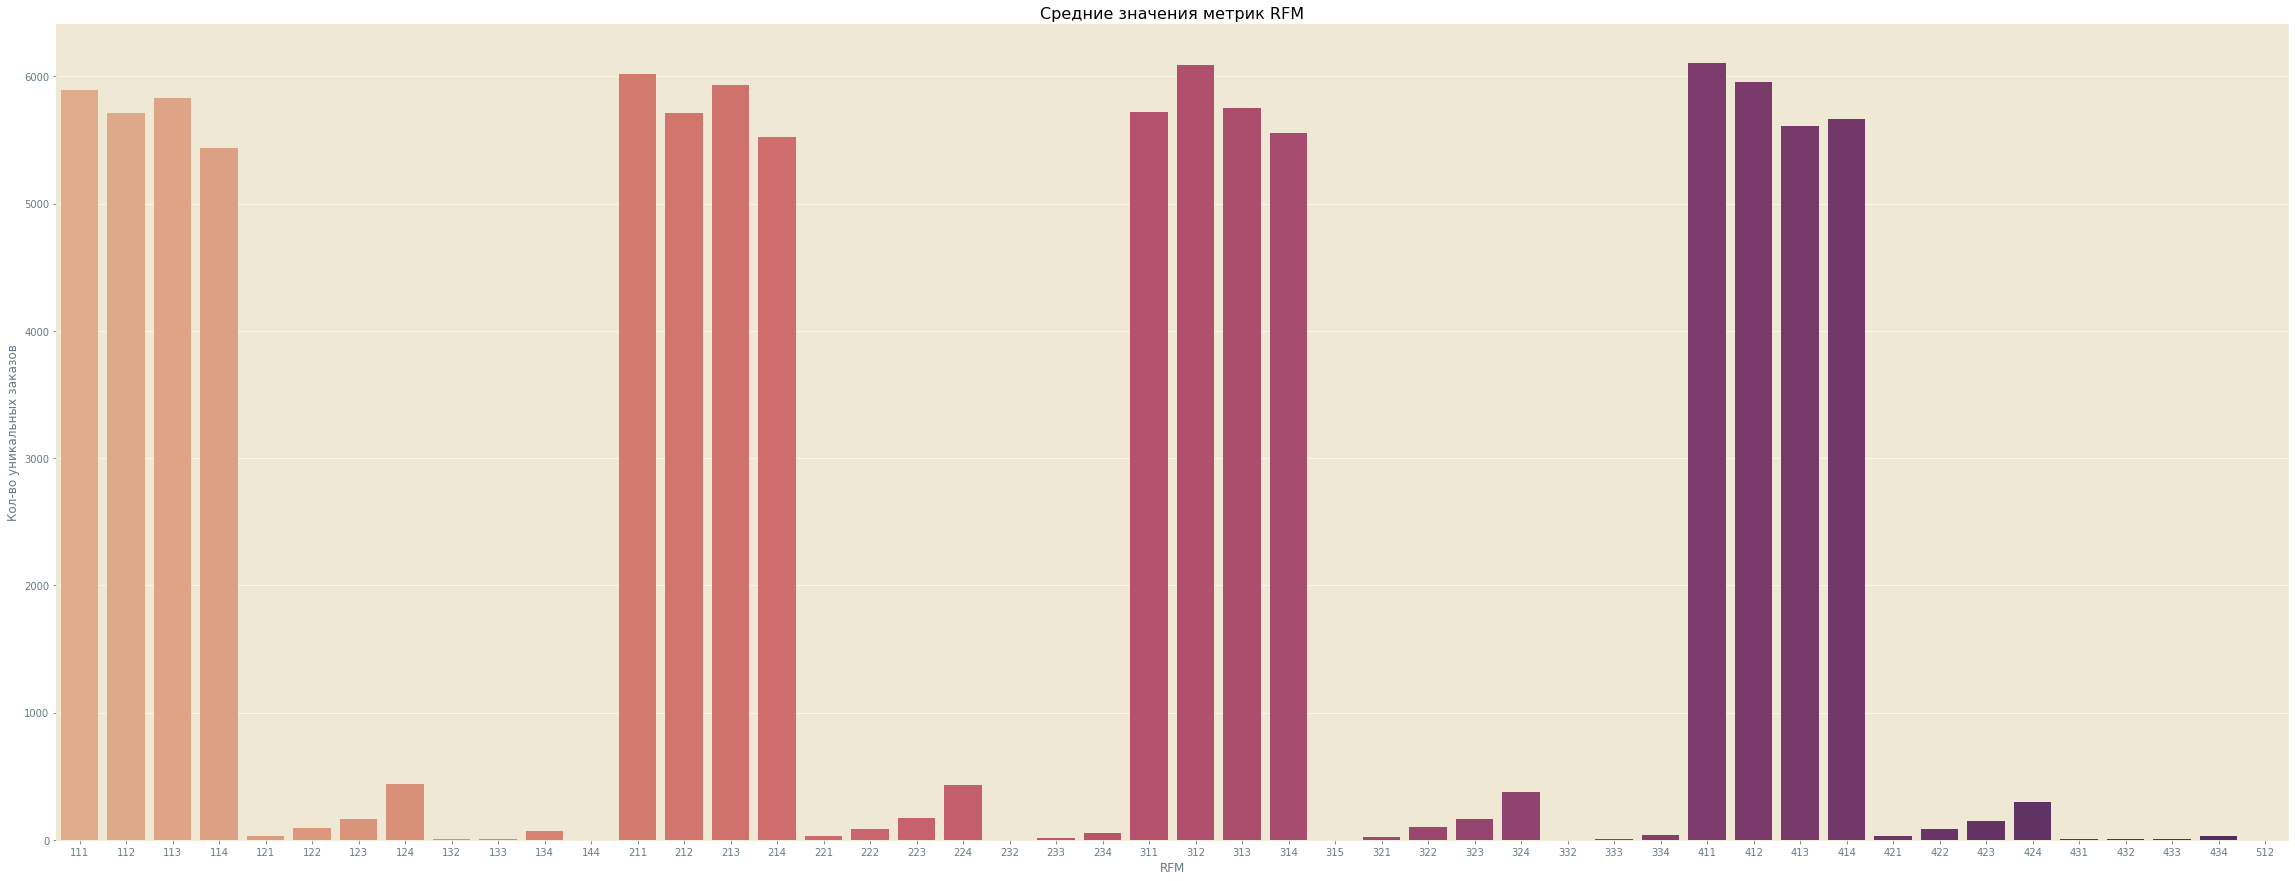

In [17]:
fig = plt.figure(figsize=(40,15))
z = sns.barplot(data=rfm_graph, x='RFM', y='num_of_customers', palette="flare")
z.set_xlabel("RFM")
z.set_ylabel("Кол-во уникальных заказов")
z.set(title="Средние значения метрик RFM")
plt.show()
